In [9]:
import torch
from torch.utils.data import TensorDataset

from torchcp.regression import Metrics
from torchcp.regression.loss import QuantileLoss
from torchcp.regression.predictors import ACI, CQR
from torchcp.utils import fix_randomness
from torchcp_utils.dataset import build_reg_data
from torchcp_utils.utils import build_regression_model
from torchcp_utils.regression import train

In [10]:
if __name__ == '__main__':

    ##################################
    # Preparing dataset
    ##################################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fix_randomness(seed=2)
    X, y = build_reg_data(data_name="synthetic")
    num_examples = X.shape[0]
    T0 = int(num_examples * 0.4)
    train_dataset = TensorDataset(torch.from_numpy(X[:T0, :]), torch.from_numpy(y[:T0]))
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=True)


    alpha = 0.1
    quantiles = [alpha / 2, 1 - alpha / 2]
    model = build_regression_model("NonLinearNet")(X.shape[1], 2, 64, 0.5).to(device)
    criterion = QuantileLoss(quantiles)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    epochs = 10
    for epoch in range(epochs):
        train(model, device, epoch, train_data_loader, criterion, optimizer)
            
    model.eval()        
    ##################################
    # Conformal Quantile Regression
    ##################################
    print("########################## CQR ###########################")

    predictor = CQR(model)
    cal_dataset = TensorDataset(torch.from_numpy(X[0:T0, :]), torch.from_numpy(y[0:T0]))
    test_dataset = TensorDataset(torch.from_numpy(X[T0:, :]), torch.from_numpy(y[T0:]))
    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)
    predictor.calibrate(cal_data_loader, alpha)
    print(predictor.evaluate(test_data_loader))      

    ##################################
    # Adaptive Conformal Inference,
    ##################################      
    print("########################## ACI ###########################")
    predictor = ACI(model, 0.0001)
    test_y = torch.from_numpy(y[T0:num_examples]).to(device)
    predicts = torch.zeros((num_examples - T0, 2)).to(device)
    for i in range(num_examples - T0):
        with torch.no_grad():
            cal_dataset = TensorDataset(torch.from_numpy(X[i:(T0 + i), :]), torch.from_numpy(y[i:(T0 + i)]))
            cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
            predictor.calibrate(cal_data_loader, alpha)
            tmp_x = torch.from_numpy(X[(T0 + i), :])
            if i == 0:
                tmp_prediction_intervals = predictor.predict(tmp_x)
            else:
                tmp_prediction_intervals = predictor.predict(tmp_x, test_y[i - 1], predicts[i - 1])
            predicts[i, :] = tmp_prediction_intervals

    metrics = Metrics()
    print("Evaluating prediction sets...")
    print(f"Coverage_rate: {metrics('coverage_rate')(predicts, test_y)}")
    print(f"Average_size: {metrics('average_size')(predicts)}")

########################## CQR ###########################
{'Coverage_rate': tensor([0.7967]), 'Average_size': tensor([27.8324])}
########################## ACI ###########################
Evaluating prediction sets...
Coverage_rate: tensor([0.8767])
Average_size: 30.973995208740234


In [1]:
# %matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./dataset/bike_sharing_daily.csv')
display(data.tail())
# convert string to datetime64
data["ds"] = pd.to_datetime(data["dteday"])
df = data[['ds','cnt']]
df.columns = ['ds','y']

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [3]:
from neuralprophet import NeuralProphet
quantile_list=[0.05,0.95 ]
# Model and prediction
cqr_model = NeuralProphet(
    quantiles=quantile_list,
    #n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    # Add the autogression
    #n_lags=10,
    # Forecast the next 50 days
    #n_forecasts= 50
)
cqr_model = cqr_model.add_country_holidays("US")
#cqr_model.set_plotting_backend("matplotlib")  # Use matplotlib

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


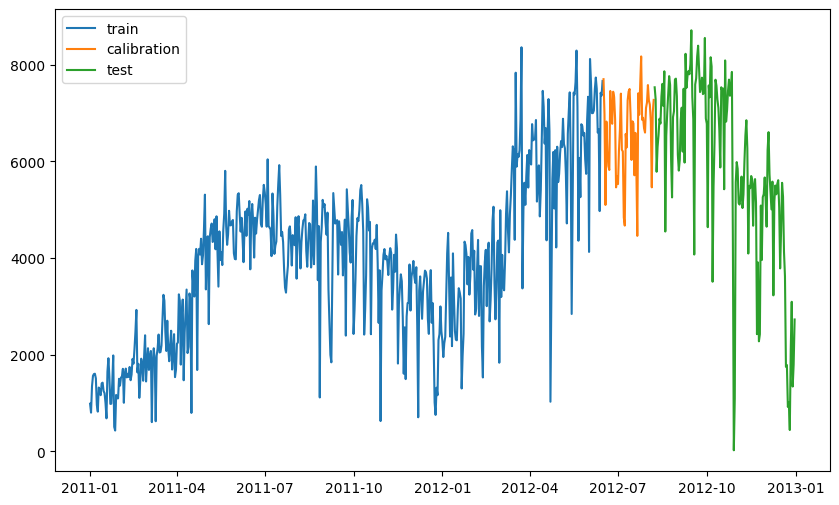

In [5]:
df_train, df_test = cqr_model.split_df(df, valid_p=0.2)
df_train, df_cal = cqr_model.split_df(df_train, freq="D", valid_p=1.0 / 11)
[df_train.shape, df_test.shape, df_cal.shape]

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df_train.ds, df_train.y, label="train")
ax.plot(df_cal.ds, df_cal.y, label="calibration")
ax.plot(df_test.ds, df_test.y, label="test")
ax.legend()
plt.show()

In [6]:
metrics = cqr_model.fit(df_train, validation_df=df_cal, progress="bar")
metrics.tail()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 140
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (17) is too small than the required number                     for the learning rate finder (220). The results might not be optimal.
Finding best initial lr: 100%|██████████| 220/220 [00:01<00:00, 145.60it/s]


Epoch 140: 100%|██████████| 140/140 [00:00<00:00, 1076.07it/s, loss=0.0274, v_num=1, MAE_val=681.0, RMSE_val=878.0, Loss_val=0.0422, RegLoss_val=0.000, MAE=588.0, RMSE=811.0, Loss=0.0287, RegLoss=0.000]   


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
135,680.097595,879.062927,0.042210,0.0,135,590.756836,816.016296,0.028950,0.0
136,680.514099,880.060608,0.042293,0.0,136,595.299316,820.483398,0.029106,0.0
137,681.131104,880.820923,0.042316,0.0,137,591.881958,812.933472,0.028976,0.0
138,680.622864,879.561340,0.042246,0.0,138,588.709412,809.487000,0.028832,0.0
139,680.665955,878.182495,0.042150,0.0,139,588.149292,810.889038,0.028698,0.0


In [7]:
future = cqr_model.make_future_dataframe(df, periods=50, 
     n_historic_predictions=True)

# Parameter for CQR
method = "cqr"
alpha = 0.05
# Enable conformal prediction on the pre-trained models
cqr_forecast = cqr_model.conformal_predict(
    # df_test, # You can also use df_test
    future,
    calibration_df=df_cal,
    alpha=alpha,
    method=method,
    show_all_PI=True,
)
cqr_forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 50 rows at the end with NaNs in 'y' column.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.87it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat1 95.0% - qhat1,yhat1 5.0% + qhat1,trend,season_yearly,season_weekly,events_additive,event_Christmas Day,...,event_Martin Luther King Jr. Day,event_Memorial Day,event_New Year's Day,event_New Year's Day (observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (observed),event_Washington's Birthday,yhat1 5.0%,yhat1 95.0%
0,2011-01-01,985,758.077271,-79.686157,1723.054688,2863.099365,-1829.594116,78.140388,-353.568390,0.0,...,0.0,0.0,-353.56839,0.0,0.0,0.0,0.0,0.000000,406.723511,1236.645020
1,2011-01-02,801,923.662476,-448.707123,2333.681641,2861.442383,-1821.357178,-116.422791,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,37.702545,1847.271973
2,2011-01-03,1349,956.906372,-218.412537,2215.080322,2859.785889,-1811.922485,-90.956871,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,267.997131,1728.670654
3,2011-01-04,1562,1053.957031,67.165222,2411.713867,2858.128906,-1801.458740,-2.713152,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,553.574890,1925.304321
4,2011-01-05,1600,917.704712,-307.121338,2289.484863,2856.472168,-1790.054688,-148.712738,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,179.288345,1803.075317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2013-02-15,None,5638.903320,2067.390625,6125.312988,6796.532227,-1295.428955,137.800064,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,2553.800293,5638.903320
777,2013-02-16,None,5606.179688,1480.943481,6092.589355,6801.462891,-1273.668579,78.385437,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,1967.353149,5606.179688
778,2013-02-17,None,5439.651367,1728.183105,5926.061035,6806.394043,-1250.036743,-116.705742,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,2214.592773,5439.651367
779,2013-02-18,None,4993.647949,2139.764404,5480.057617,6811.324219,-1224.687012,-90.871674,-502.117401,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,-502.117401,2626.174072,4993.647949


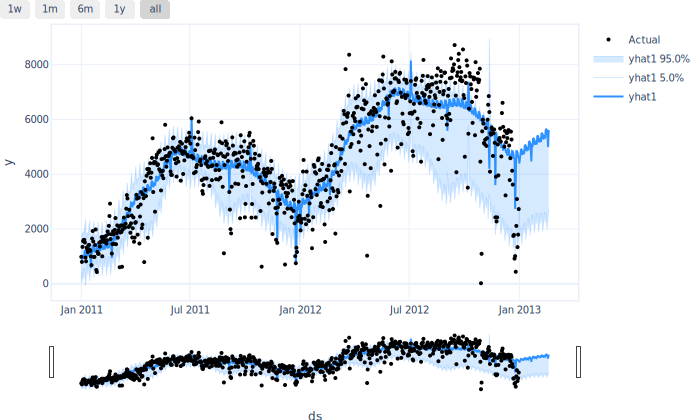

In [8]:
fig = cqr_model.plot(cqr_forecast, 
    #plotting_backend = "matplotlib"
    plotting_backend="plotly-static"
)